# Predicting temperature
By Mahfuz Miah, Oct 27, 2019

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

First, load the dataset from the weatherinszeged table from Thinkful's database.
Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model
from fractions import Fraction
import statsmodels.api as sm
import seaborn as sns

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
# prosgres credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [4]:
# import the dataframe
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [5]:
# what's inside?
weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


In [6]:
# what are the data types, how many values are in each column?
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [7]:
#what's missing from the dataframe?
def percentmissing (df):
    numer = df.isnull().sum() 
    denom = df.isnull().count()

    data= []
    i = 0
    for x,y in zip(numer,denom):
        data.append([numer.index[i],(Fraction(x,y)), x*100/y])
        i+=1
    
    df1 = pd.DataFrame(data,columns = ['Column_Name', 'Fraction of Missing Data','Percent'])
    return df1

percentmissing(weather_df)

,Column_Name,Fraction of Missing Data,Percent
0,date,0,0.000
1,summary,0,0.000
2,preciptype,0,0.000
3,temperature,0,0.000
4,apparenttemperature,0,0.000
5,humidity,0,0.000
6,windspeed,0,0.000
7,windbearing,0,0.000
8,visibility,0,0.000
9,loudcover,0,0.000


No data is missing, yay!

### Exploratory Data Analysis:

Target Variable: 'temperature'

In [8]:
weather_df.corr()['temperature'].sort_values(ascending=False)

temperature            1.000
apparenttemperature    0.993
visibility             0.393
windbearing            0.030
windspeed              0.009
pressure              -0.005
humidity              -0.632
loudcover                nan
Name: temperature, dtype: float64

Explanatory Variables of Interest: 'humidity', 'windspeed', 'windbearing', and 'pressure'

### Model:
Build your initial model using these features and estimate the parameters using OLS

One way to model and get relavent info:

In [9]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [10]:
# Y is the target variable
Y = weather_df['temperature']
# X is the feature set which includes explanatory variables.
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.926438185285306


In [11]:
Y = weather_df['temperature']
# X is the feature set which includes explanatory variables.
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:51:29   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption one: linearity of the model in its coefficients

In [12]:
# predictions of the linear regression
predictions = lrm.predict(weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']])

In [13]:
# reset X
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]
X.head()

,humidity,windspeed,windbearing,pressure
0,0.890,14.120,251.000,1015.130
1,0.860,14.265,259.000,1015.630
2,0.890,3.928,204.000,1015.940
3,0.830,14.104,269.000,1016.410
4,0.830,11.045,259.000,1016.510


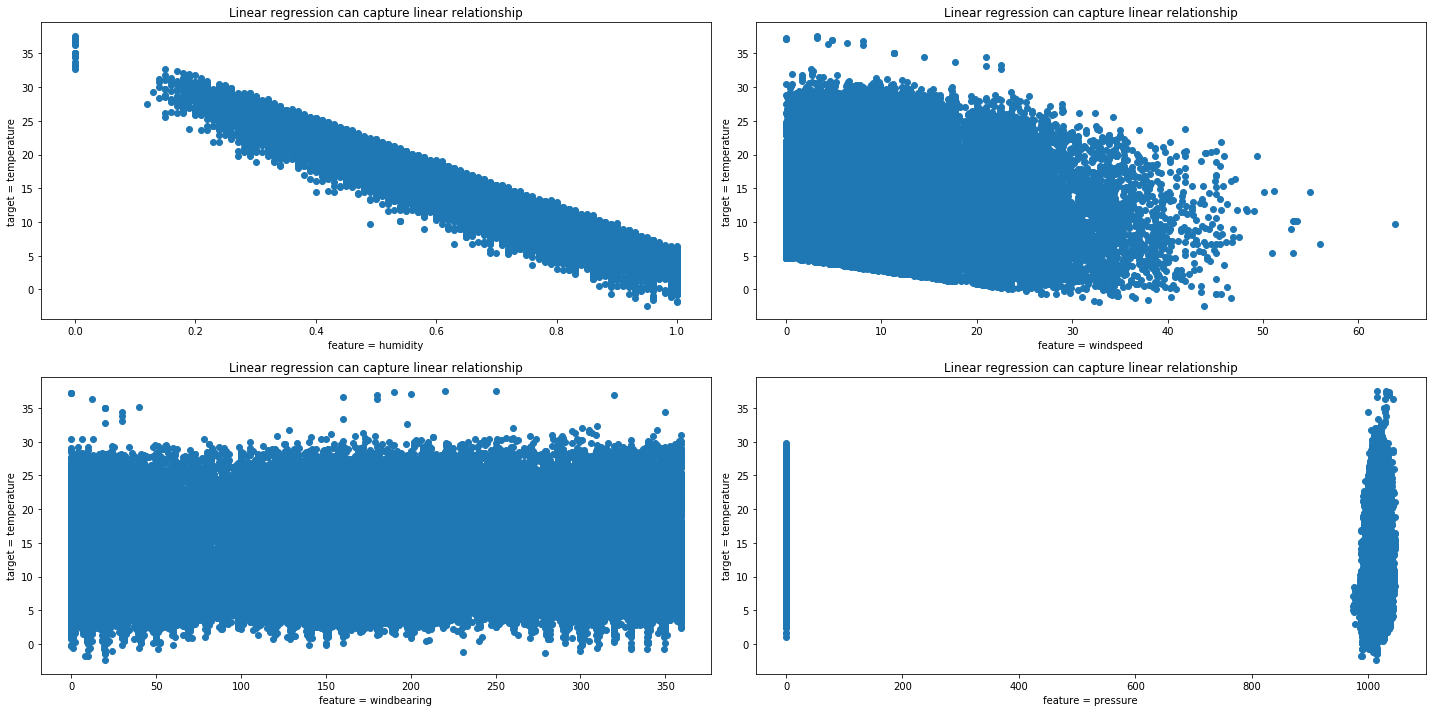

In [14]:
# we plot the estimated Y and X
# the relationship should be some linear relationship
plt.figure(figsize=(20,10))
for index,column in enumerate(X.columns):
    plt.subplot(2,2,index+1)
    plt.scatter(weather_df[column], predictions)
    plt.xlabel(f"feature = {column}")
    plt.ylabel("target = temperature")
    plt.title('Linear regression can capture linear relationship')

plt.tight_layout()
plt.show()

Most of the variables look to have some linear relationship except pressure which has two clusters of points.

## Assumption two: the error term should be zero on average

In [15]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

Mean of the errors in the weather model is: -3.589031633527646e-15


This is pretty close to zero.

## Assumption three: homoscedasticity

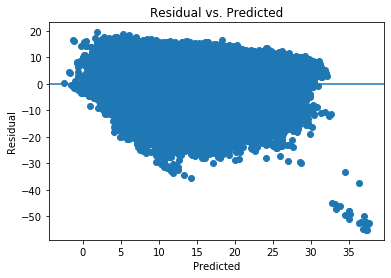

In [16]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [17]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The null hypothesis for both tests is that the errors are homoscedastic. We reject the null hypothesis here since p values are less than .05

## Assumption four: low multicollinearity

In [18]:
weather_df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060
loudcover,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000


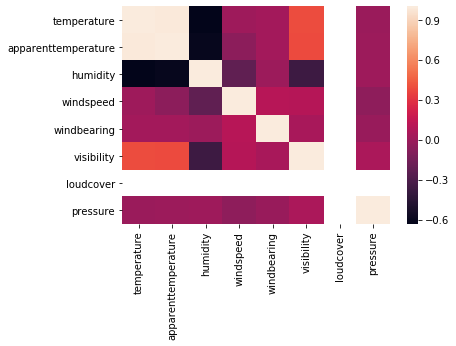

In [19]:
sns.heatmap(weather_df.corr())

We see clear collinearity between temperature and apparenttemperature. However, our model does not include this so this is not a problem.

## Assumption five: error terms should be uncorrelated with one another

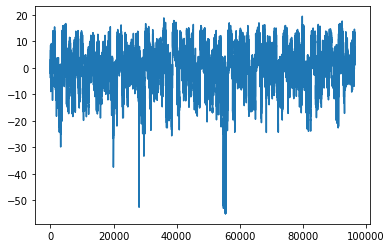

In [20]:
plt.plot(errors)
plt.show()

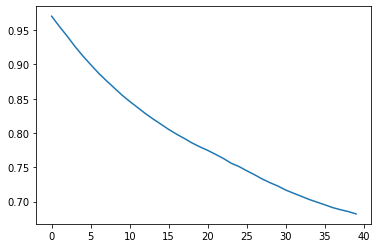

In [21]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The autocorrelation between the errors of our temperature model ranges between .95 and .65.

## Assumption six: features shouldn't be correlated with the errors

This assumption is: explanatory variables and errors should be independent. The estimates of the coefficients would be biased if this doens't hold. This assumption is known as the exogeneity.
Violations of the exogeneity assumption may have several sources. We have avoided the common causes of this which usually are omitted variables and simultaneous causation between independent variables and the target.

## Normality of the errors

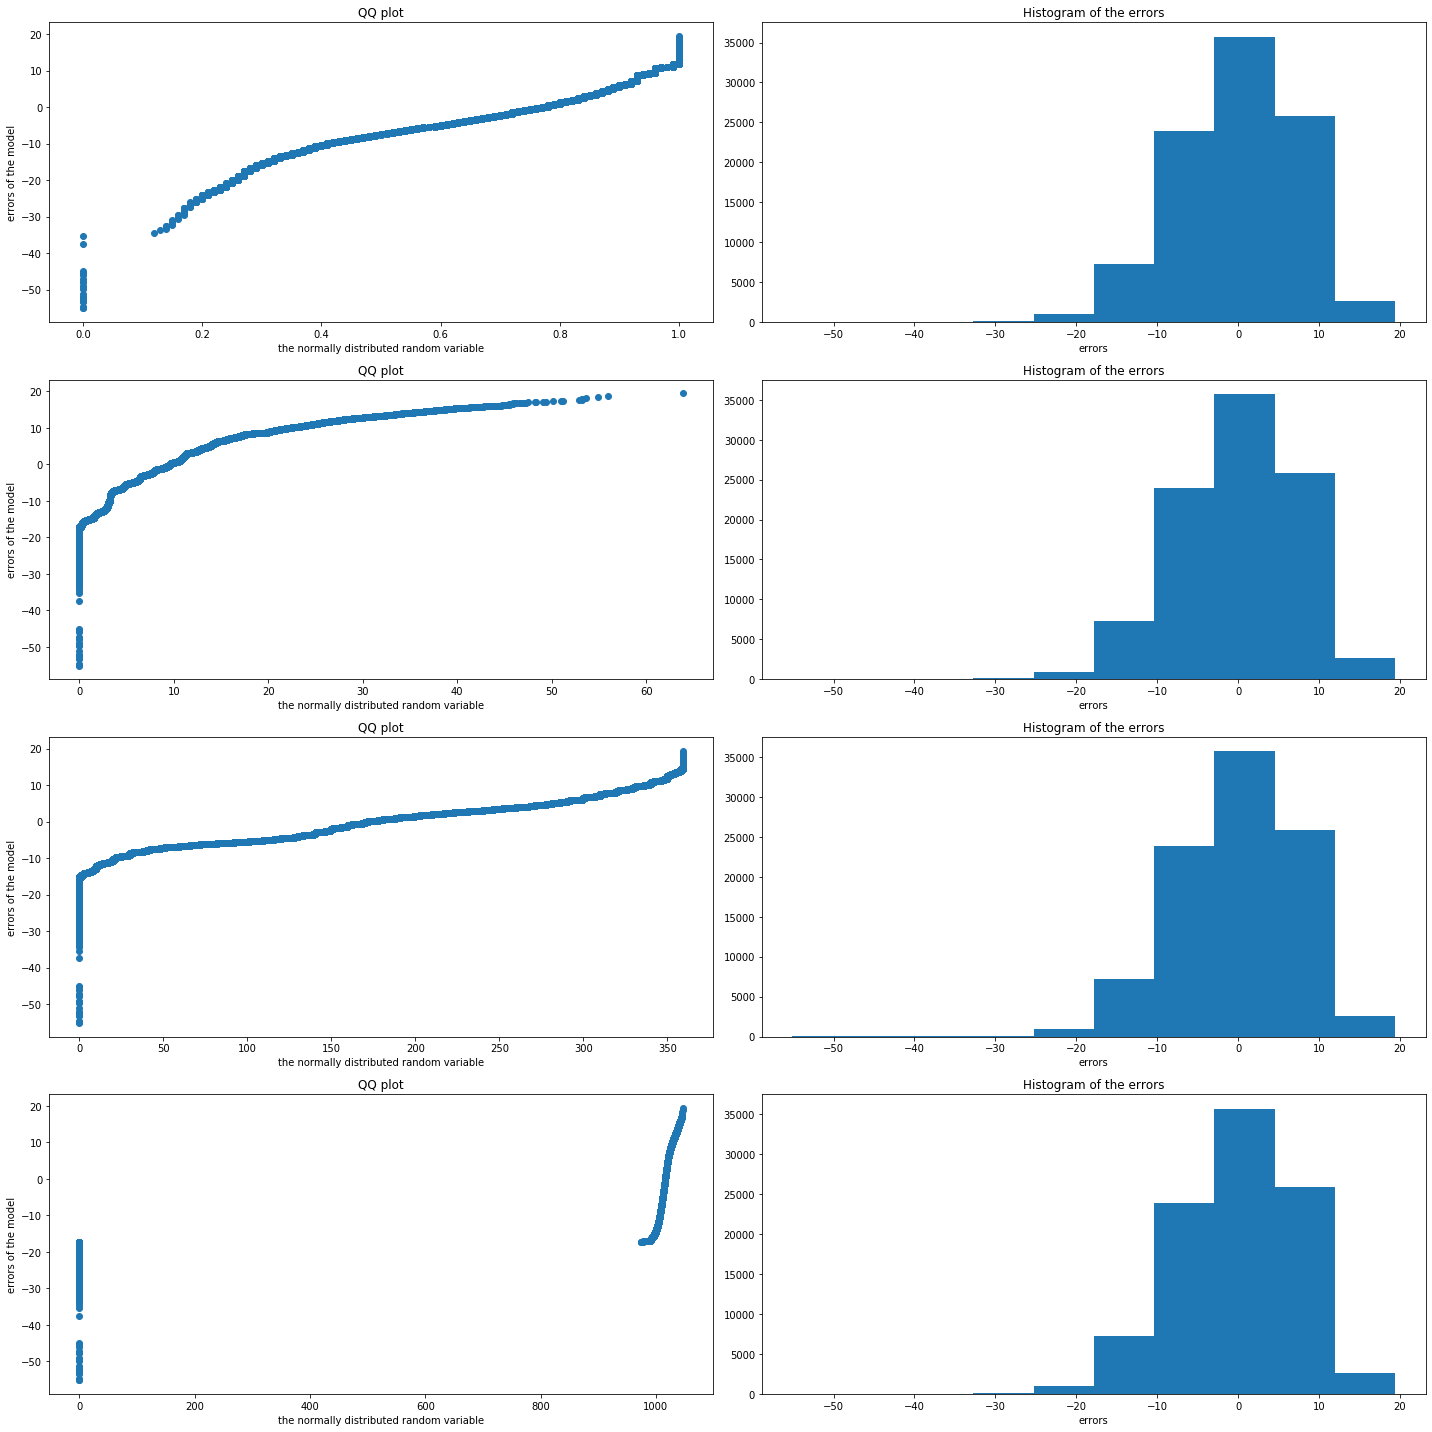

In [22]:
plt.figure(figsize=(20,20))

for index,column in enumerate(X.columns):
    plt.subplot(4,2,(index+1)*2-1)
    plt.scatter(np.sort(weather_df[column]), np.sort(errors)) # we sort the arrays
    plt.xlabel("the normally distributed random variable")
    plt.ylabel("errors of the model")
    plt.title("QQ plot")

    plt.subplot(4,2,(index+1)*2)
    plt.hist(errors)
    plt.xlabel("errors")
    plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [24]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.2967352523665 and p value is 0.0
Normality test statistics is 3375.432307699586 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.

# Revisit Weather Model, evaluating performance

**Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. What are the R-squared and adjusted R-squared values? Do you think they are satisfactory? Why?**

In [30]:
# Y is the target variable
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# X is the feature set
X = weather_df[['humidity','windspeed']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:53:28   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared of the model is 0.288 and adjusted R-squared of the model is also 0.288.

R-squared and adjusted R-squared are best when they come closer to 1. 0.288 seems relatively low so that means 71.2% of the variation in the target variable is not explained by this model. This doesn't mean that it's a bad model; it's unlikely you'll ever be able to know all the variables that contribute to complicated phenomenon. If our model explains thins too well, we also have to wonder how useful the model is in novel circumstances. Maybe it fit too well to our specific input data.

**Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Now, what is the R-squared of this model? Does this model improve upon the previous one?**


In [26]:
weather_df['humidity_windspeed_interaction'] = weather_df.humidity * weather_df.windspeed

# Y is the target variable
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# X is the feature set
X = weather_df[['humidity','windspeed', 'humidity_windspeed_interaction']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:52:02   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0839      0.033      2.511      0.012       0.018       0.149
humidity                           0.1775      0.043      4.133      0.000       0.093       0.262
windspeed                          0.0905      0.002     36.797      0.000       0.086       0.095
humidity_windspeed_interaction    -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared and adjusted R-squared values are both 0.341. 
Addition of the interaction term increased the adjusted R-squared value by 0.053 points, which means we can now explain that much more of the variance  in the target variable.

**Add visibility as an additional explanatory variable to the first model and estimate it. Did R-squared increase? What about adjusted R-squared? Compare the differences put on the table by the interaction term and the visibility in terms of the improvement in the adjusted R-squared. Which one is more useful?**

In [29]:
# Y is the target variable
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# X is the feature set
X = weather_df[['humidity','windspeed', 'visibility']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:52:44   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5756      0.028     56.605      0.000       1.521       1.630
humidity      -2.6066      0.025   -102.784      0.000      -2.656      -2.557
windspeed     -0.1199      0.001   -179.014      0.000      -0.121      -0.119
visibility     0.0540      0.001     46.614      0.000       0.052       0.056
==============================================================================
Omnibus:                     3833.895   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4584.022
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                       3.545   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared of the model: 0.304
Adjusted R-squared: 0.303. 

Both the R-squared and adjusted R-squared values are greater compared to the first model. We impoved the adjusted R-squared value by (.303-.288) = .015 point. 

This improvment is not as good as the improvement we arrive at by including an interaction term in the model. Therefore, this intereaction term is more explanatory than visibility in explaining the features that contribute to the target variable. 

**Choose the best one from the three models above with respect to their AIC and BIC scores. Validate your choice by discussing your justification with your mentor.**

We desire lower values for information criterions like AIC and BIC to choose an ideal model. 
AIC and BIC for the first model: 340900. 
AIC and BIC for the second model: 333400.
AIC and BIC for the second model: 338800. 
The second model has the lowest AIC and BIC scores and therefore the best model is this second one (which also has a higher R squared and therefore explains more of the variance in the target)